t‑SNE: нелинейное вложение, оптимизирует дивергенцию Кульбака–Лейблера между распределениями близостей точек, хорошо показывает локальные кластеры, но медленно, плохо сохраняет глобальные расстояния, чувствительно к perplexity и random_state.

UMAP: основан на теории многобразий и топологии, строит взвешенный граф соседей и оптимизирует кросс‑энтропию; быстрее t‑SNE, лучше сохраняет глобальную структуру, более устойчив к малым изменениям параметров (n_neighbors, min_dist).

TriMAP: ориентирован на сохранение глобальной структуры через тройки точек (anchor, сосед, далёкий), улучшает глобальное расположение кластеров при сохранении локальной структуры.

PaCMAP: управляет соотношением близких, средних и далёких пар, чтобы одновременно хорошо держать локальные кластеры и общую форму; показывает хорошие результаты на омикс‑данных и эмбеддингах.

PHATE: использует диффузионные процессы и потенциал для визуализации непрерывных траекторий (например, дифференцировка клеток), хорошо показывает как кластеры, так и переходы между ними.



In [1]:
%pip install umap-learn trimap pacmap phate scikit-learn seaborn

Using legacy 'setup.py install' for annoy, since package 'wheel' is not installed.
    Running setup.py install for annoy: started
    Running setup.py install for annoy: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


    ERROR: Command errored out with exit status 1:
     command: 'c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\Scripts\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\User\\AppData\\Local\\Temp\\pip-install-4zigzhq0\\annoy_f40d5294055641afb48e2a4369b32780\\setup.py'"'"'; __file__='"'"'C:\\Users\\User\\AppData\\Local\\Temp\\pip-install-4zigzhq0\\annoy_f40d5294055641afb48e2a4369b32780\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record 'C:\Users\User\AppData\Local\Temp\pip-record-zda0epfw\install-record.txt' --single-version-externally-managed --compile --install-headers 'c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\include\site\python3.1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

from sklearn.manifold import TSNE
import umap
import trimap
import pacmap
import phate

In [3]:
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names_iris = iris.feature_names
print(X_iris.shape, np.unique(y_iris))


(150, 4) [0 1 2]


In [87]:
path = "../fruit_classification_dataset.csv"
df = pd.read_csv(path)
df.head()


size (cm)  shape  weight (g)  avg_price (₹)   color  taste     fruit_name
0       25.4  round      3089.2          137.1   green  sweet     watermelon
1       24.6  round      3283.9          163.8   green  sweet     watermelon
2        7.8  round       319.0           91.3   green  sweet  custard apple
3       20.0   oval      1607.0           85.7  orange  sweet         papaya
4       10.2   long       131.5           37.8  yellow  sweet         banana

In [88]:
# Ограничиваем количество классов
n_classes = 5
top_classes = df['fruit_name'].value_counts().head(n_classes).index
df = df[df['fruit_name'].isin(top_classes)]
print(f"Оставили {n_classes} самых частых классов: {list(top_classes)}")

feature_cols = [c for c in df.columns if c != "target"]
X_own = df[feature_cols]
y_own = df["fruit_name"]
print(X_own.shape, len(np.unique(y_own)))


Оставили 5 самых частых классов: ['pear', 'pomegranate', 'pineapple', 'custard apple', 'papaya']
(2626, 7) 5


In [89]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import numpy as np

# Кодируем y и сохраняем названия классов
label_encoder = LabelEncoder()
y_own = label_encoder.fit_transform(y_own)
class_names = label_encoder.classes_

print(f"\nВсего записей: {len(df)}")
print(f"Количество классов: {len(class_names)}")
print(f"Классы: {class_names}")

# Преобразуем X
numerical_features = ['size (cm)', 'weight (g)', 'avg_price (₹)']
categorical_features = ['shape', 'color', 'taste']

# OneHot кодирование категориальных признаков
ohe = OneHotEncoder(drop='first', sparse_output=False)
X_cat = ohe.fit_transform(df[categorical_features])
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# Числовые признаки оставляем как есть
X_num = df[numerical_features].values

# Объединяем
X_own = np.hstack([X_cat, X_num])
feature_names = list(cat_feature_names) + numerical_features


Всего записей: 2626
Количество классов: 5
Классы: ['custard apple' 'papaya' 'pear' 'pineapple' 'pomegranate']


In [90]:
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)
X_own_scaled = scaler.fit_transform(X_own)

Функции для DR и оценки разделения

In [65]:
def run_tsne(X, random_state=42, perplexity=30, learning_rate=200, n_iter=1000):
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate=learning_rate,
        random_state=random_state
    )
    return tsne.fit_transform(X)

def run_umap(X, random_state=42, n_neighbors=15, min_dist=0.1):
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )
    return reducer.fit_transform(X)

def run_trimap(X, random_state=42, n_inliers=10, n_outliers=5):
    reducer = trimap.TRIMAP(
        n_dims=2,
        n_inliers=n_inliers,
        n_outliers=n_outliers
    )
    return reducer.fit_transform(X)

def run_pacmap(X, random_state=42, n_neighbors=10):
    reducer = pacmap.PaCMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        random_state=random_state
    )
    return reducer.fit_transform(X)

def run_phate(X, random_state=42, knn=15):
    phate_op = phate.PHATE(
        n_components=2,
        knn=knn,
        random_state=random_state
    )
    return phate_op.fit_transform(X)

Функция оценки качества разделения

In [66]:
def separation_score(X_2d, y):
    D = pairwise_distances(X_2d)
    same = D[y[:, None] == y[None, :]]
    diff = D[y[:, None] != y[None, :]]
    return same.mean(), diff.mean(), diff.mean() / same.mean()


In [67]:
# Отрисовка

def plot_embedding(X_2d, y, title):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=X_2d[:, 0],
        y=X_2d[:, 1],
        hue=y,
        palette="tab10",
        s=30,
        legend="full"
    )
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.legend(title="Класс", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Calculating PHATE...
  Running PHATE on 150 observations and 4 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...


c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\lib\site-packages\graphtools\graphs.py:803: RuntimeWarning: Detected zero distance between samples 101 and 142. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 0.71 seconds.
  Calculated graph and diffusion operator in 0.72 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 0.01 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed by -1.4% in final iterations. Consider increasing n_iter or adjusting learning_rate.
  Calculated metric MDS in 0.08 seconds.
Calculated PHATE in 0.82 seconds.


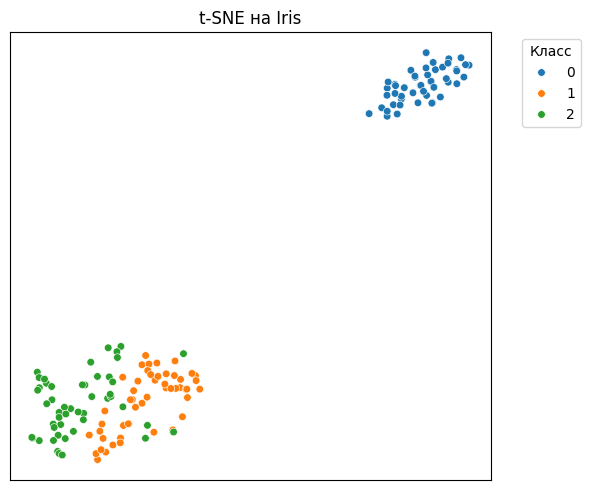

t-SNE: внутрикласс.=3.512, межкласс.=22.740, ratio=6.475


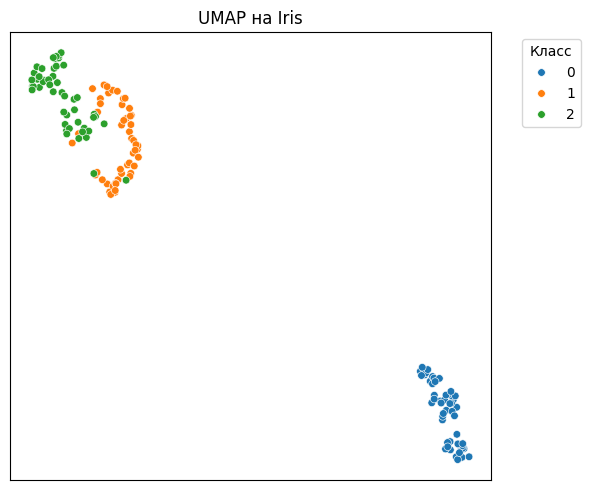

UMAP: внутрикласс.=1.830, межкласс.=13.479, ratio=7.364


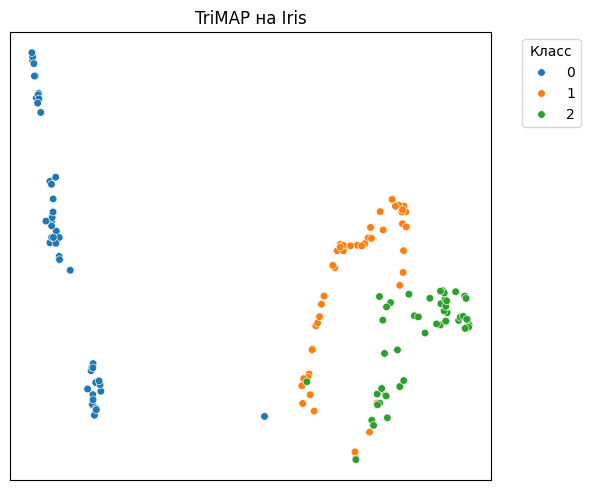

TriMAP: внутрикласс.=11.386, межкласс.=60.606, ratio=5.323


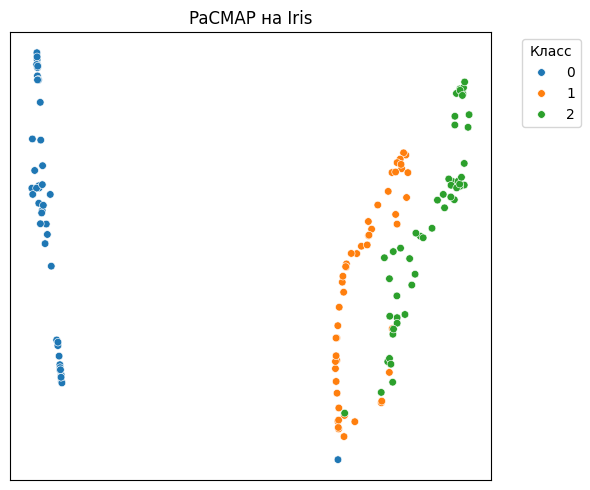

PaCMAP: внутрикласс.=3.471, межкласс.=17.697, ratio=5.099


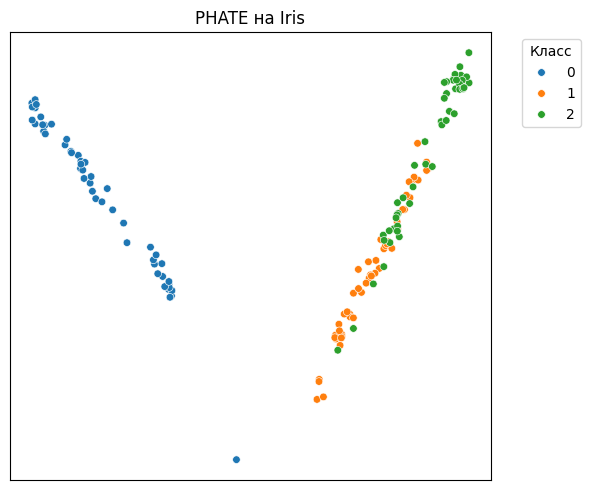

PHATE: внутрикласс.=0.026, межкласс.=0.121, ratio=4.610


In [ ]:
X_list = []
names = []

X_tsne_iris = run_tsne(X_iris_scaled, random_state=42)
X_list.append(X_tsne_iris); names.append("t-SNE")

X_umap_iris = run_umap(X_iris_scaled, random_state=42)
X_list.append(X_umap_iris); names.append("UMAP")

X_trimap_iris = run_trimap(X_iris_scaled, random_state=42)
X_list.append(X_trimap_iris); names.append("TriMAP")

X_pacmap_iris = run_pacmap(X_iris_scaled, random_state=42)
X_list.append(X_pacmap_iris); names.append("PaCMAP")

X_phate_iris = run_phate(X_iris_scaled, random_state=42)
X_list.append(X_phate_iris); names.append("PHATE")

for X_emb, name in zip(X_list, names):
    plot_embedding(X_emb, y_iris, f"{name} на Iris")
    same, diff, ratio = separation_score(X_emb, y_iris)
    print(
        f"{name}: внутрикласс.={same:.3f}, межкласс.={diff:.3f}, ratio={ratio:.3f}"
    )

c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Calculating PHATE...
  Running PHATE on 2626 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 0.10 seconds.
  Calculating landmark operator...
    Calculating SVD...


c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\lib\site-packages\phate\phate.py:919: RuntimeWarning: Graph is disconnected with 5 connected components. This may indicate that your knn parameter (currently 15) is too small, or that your data contains distinct clusters. PHATE may not accurately represent relationships between disconnected components.
  warnings.warn(


    Calculated SVD in 0.93 seconds.
    Calculating KMeans...
    Calculated KMeans in 0.90 seconds.
  Calculated landmark operator in 1.83 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 0.74 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.24 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.49 seconds.
Calculated PHATE in 4.67 seconds.


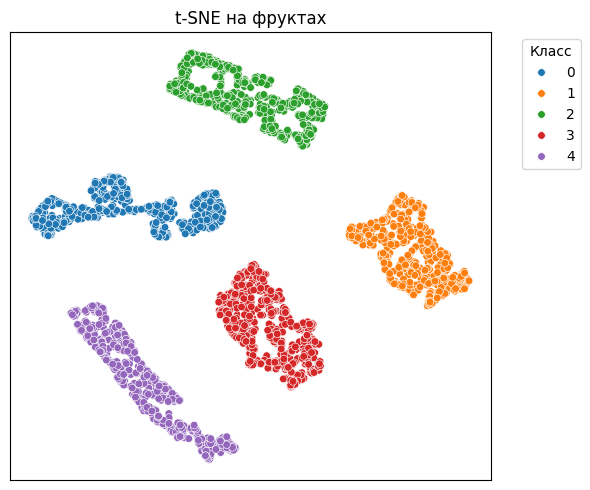

t-SNE: внутрикласс.=19.401, межкласс.=70.357, ratio=3.626


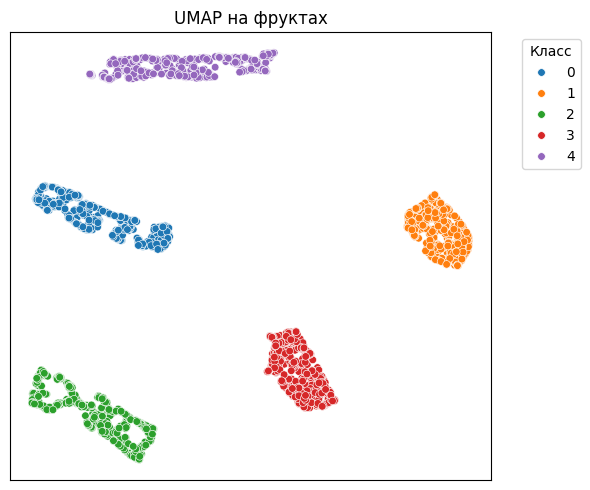

UMAP: внутрикласс.=2.974, межкласс.=17.131, ratio=5.760


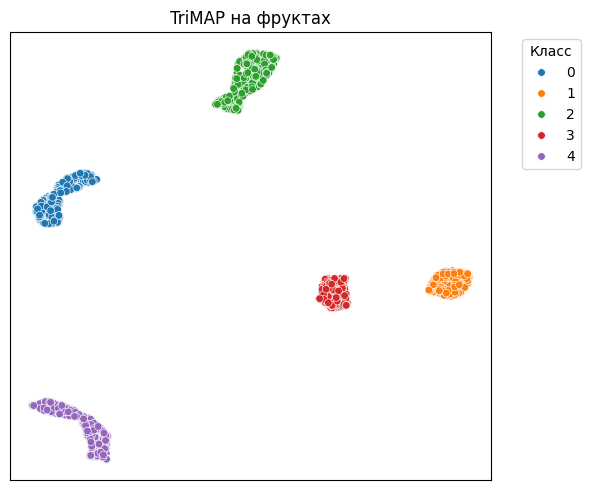

TriMAP: внутрикласс.=11.133, межкласс.=122.693, ratio=11.021


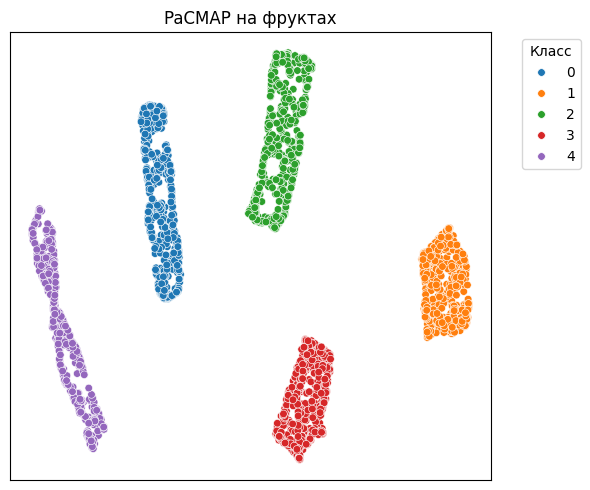

PaCMAP: внутрикласс.=5.161, межкласс.=25.332, ratio=4.908


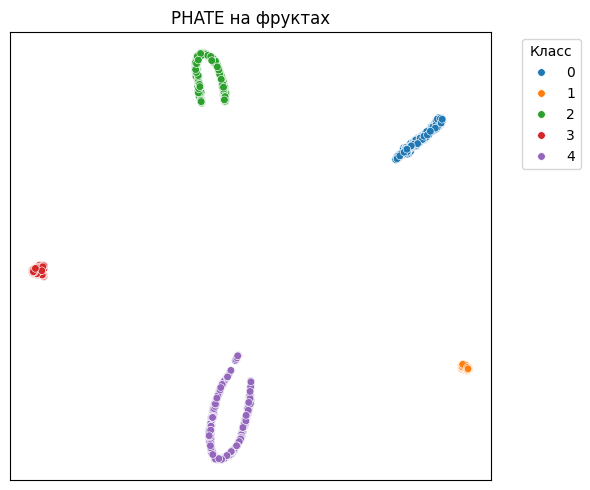

PHATE: внутрикласс.=0.002, межкласс.=0.027, ratio=16.434


In [74]:
X_list = []
names = []

X_tsne = run_tsne(X_own_scaled, random_state=42)
X_list.append(X_tsne); names.append("t-SNE")

X_umap = run_umap(X_own_scaled, random_state=42)
X_list.append(X_umap); names.append("UMAP")

X_trimap = run_trimap(X_own_scaled, random_state=42)
X_list.append(X_trimap); names.append("TriMAP")

X_pacmap = run_pacmap(X_own_scaled, random_state=42)
X_list.append(X_pacmap); names.append("PaCMAP")

X_phate = run_phate(X_own_scaled, random_state=42)
X_list.append(X_phate); names.append("PHATE")

for X_emb, name in zip(X_list, names):
    plot_embedding(X_emb, y_own, f"{name} на фруктах")
    same, diff, ratio = separation_score(X_emb, y_own)
    print(
        f"{name}: внутрикласс.={same:.3f}, межкласс.={diff:.3f}, ratio={ratio:.3f}"
    )

Сравнение устойчивости

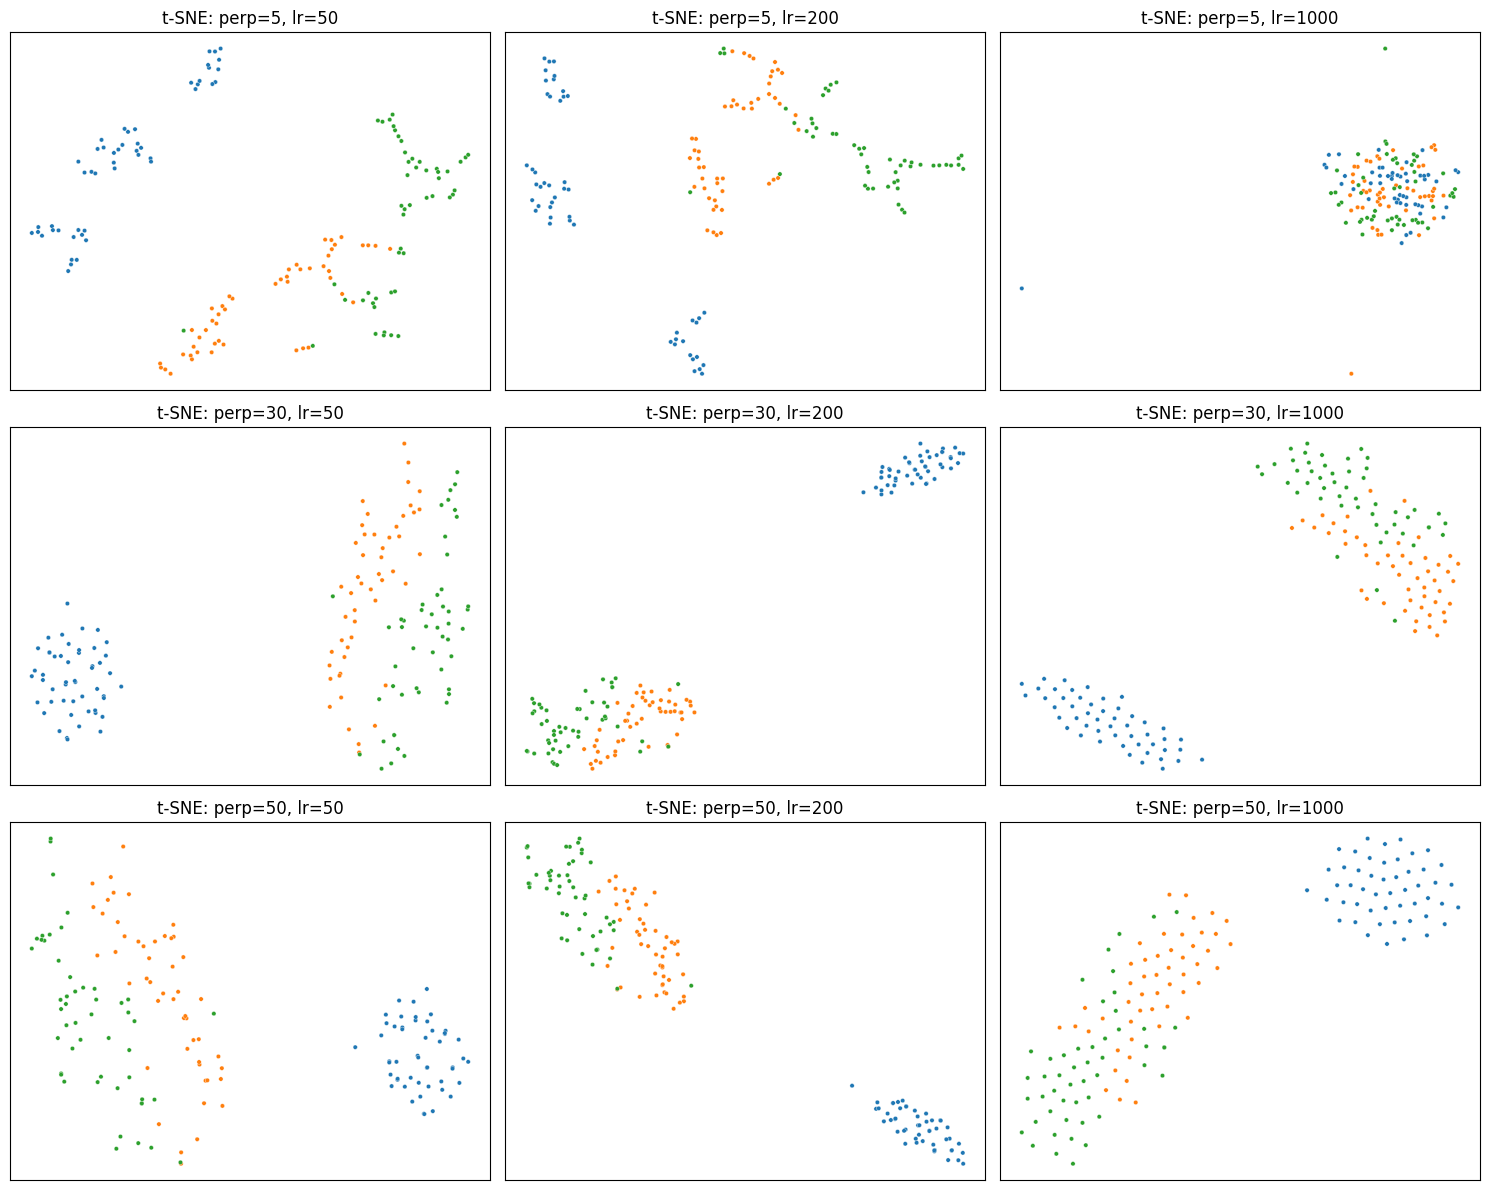

In [75]:
perplexities = [5, 30, 50]
lrs = [50, 200, 1000]

fig, axes = plt.subplots(len(perplexities), len(lrs), figsize=(5*len(lrs), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(lrs):
        X_emb = run_tsne(X_iris_scaled, random_state=42, perplexity=perp, learning_rate=lr)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=y_iris, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"t-SNE: perp={perp}, lr={lr}")
        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()


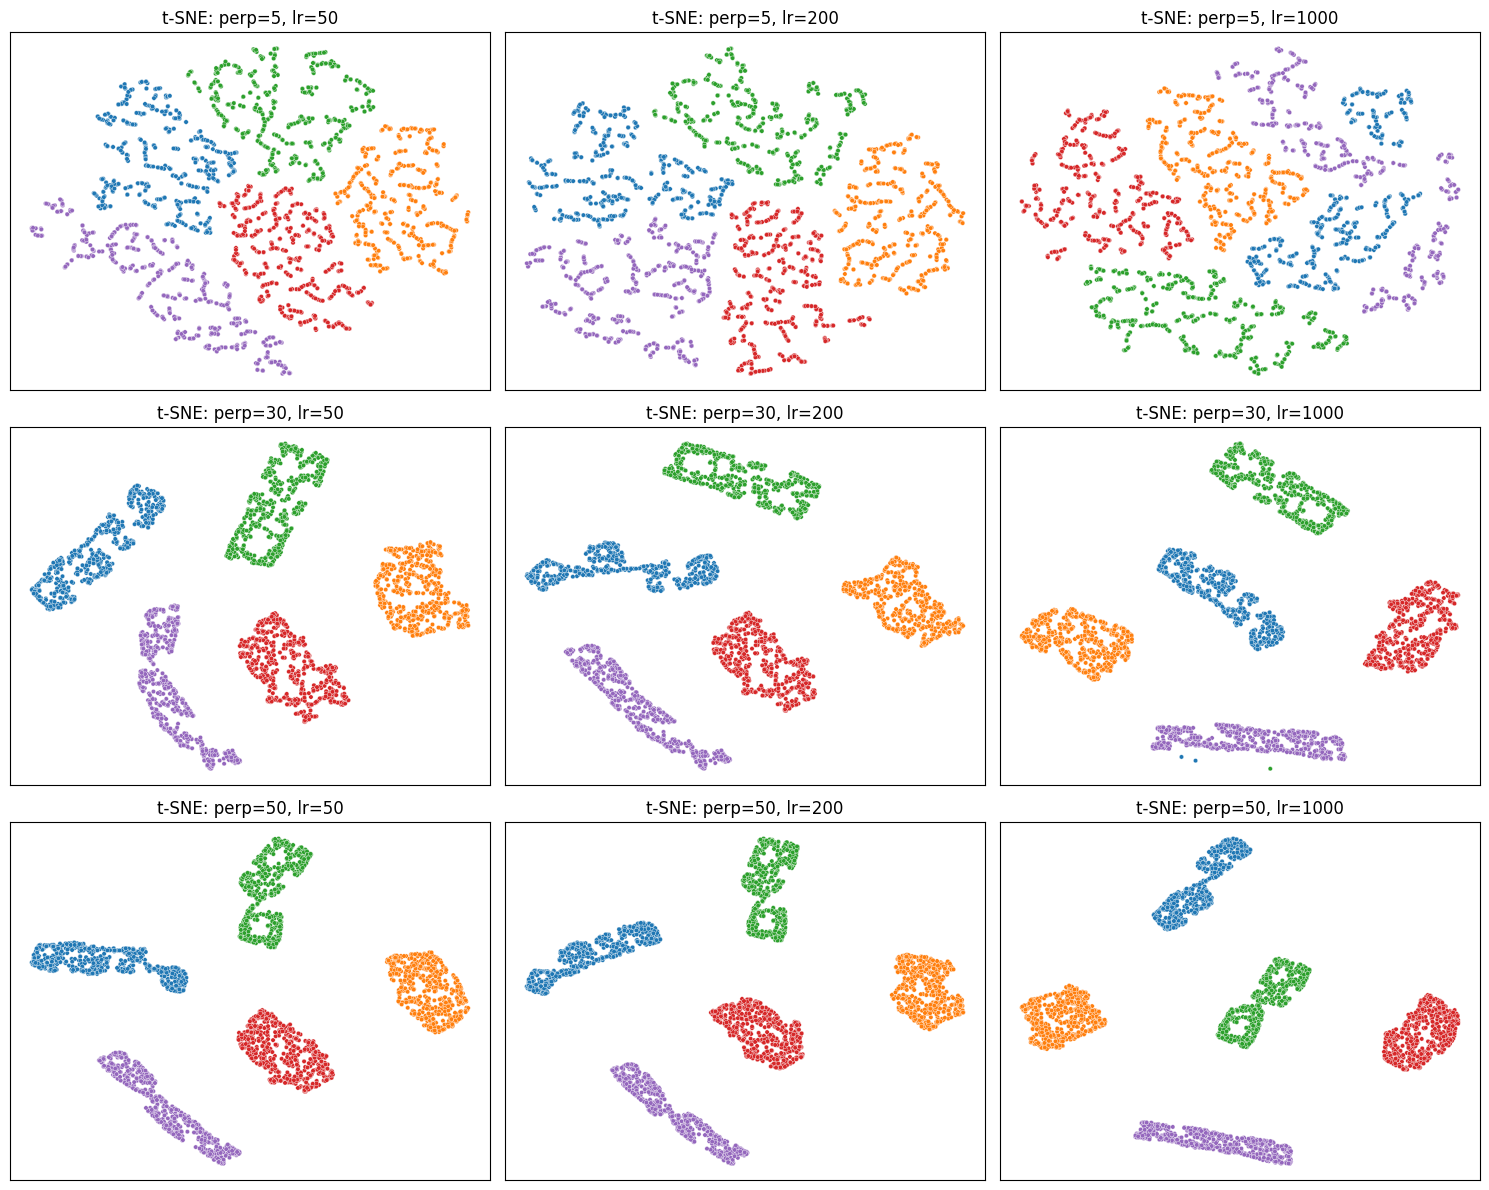

In [76]:
perplexities = [5, 30, 50]
lrs = [50, 200, 1000]

fig, axes = plt.subplots(len(perplexities), len(lrs), figsize=(5*len(lrs), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(lrs):
        X_emb = run_tsne(X_own_scaled, random_state=42, perplexity=perp, learning_rate=lr)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=y_own, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"t-SNE: perp={perp}, lr={lr}")
        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()


Нужно описать, как меняется форма и расположение кластеров при разных perplexity и learning_rate и что визуализация t‑SNE может сильно меняться.

c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\lib\site-packa

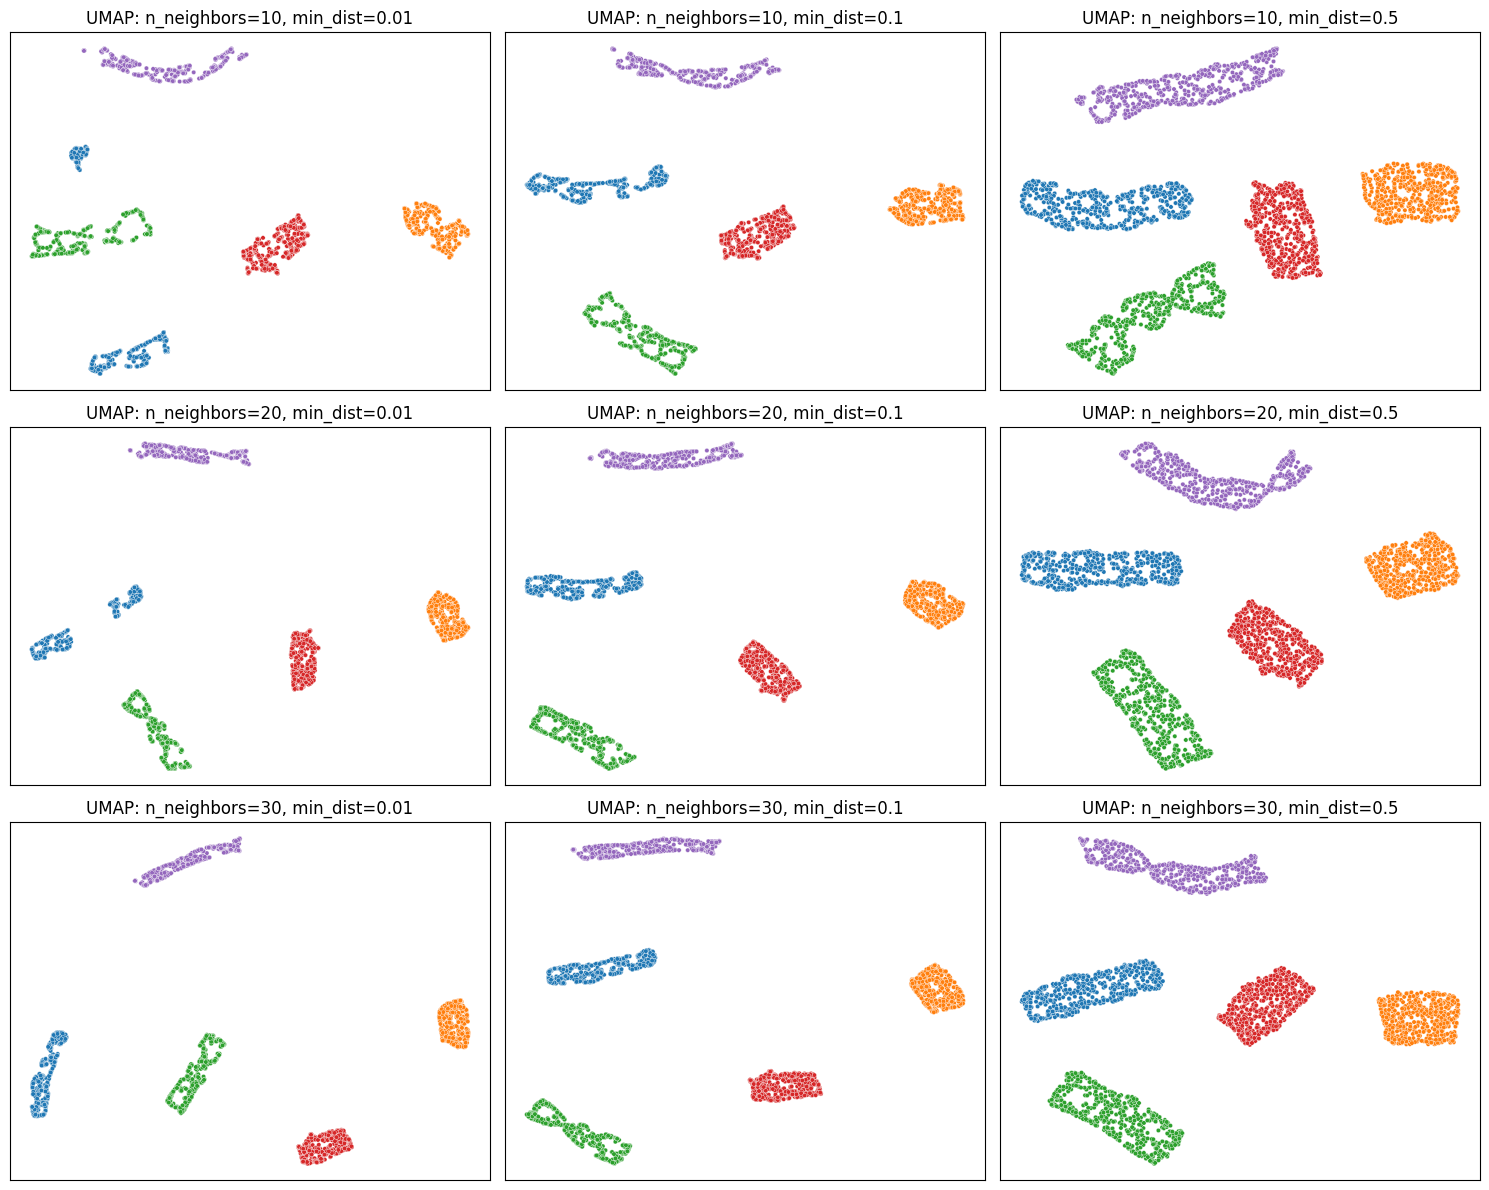

In [77]:
n_neighbors = [10, 20, 30]
min_dists = [0.01, 0.1, 0.5]

fig, axes = plt.subplots(len(perplexities), len(lrs), figsize=(5*len(lrs), 4*len(perplexities)))

for i, n_neighbor in enumerate(n_neighbors):
    for j, min_dist in enumerate(min_dists):
        X_emb = run_umap(X_own_scaled, random_state=42, n_neighbors=n_neighbor, min_dist=min_dist)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=y_own, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"UMAP: n_neighbors={n_neighbor}, min_dist={min_dist}")
        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()


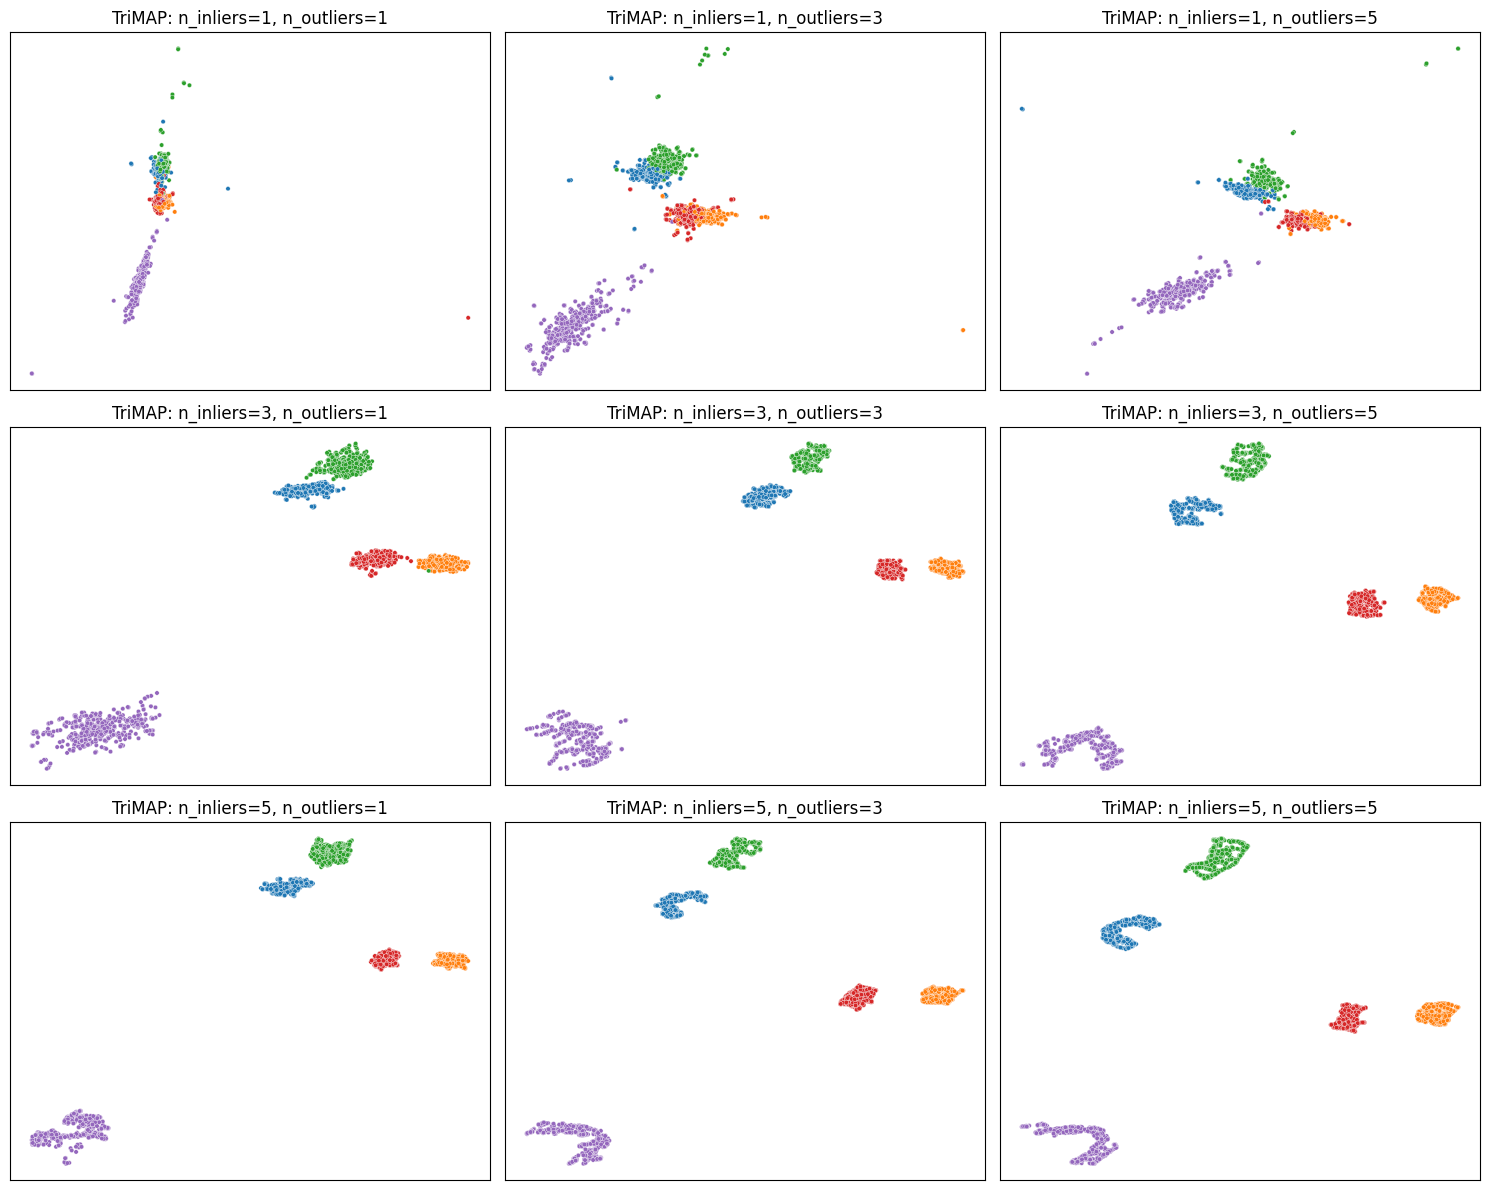

In [78]:
n_inliers = [1, 3, 5]
n_outliers = [1, 3, 5]

fig, axes = plt.subplots(len(perplexities), len(lrs), figsize=(5*len(lrs), 4*len(perplexities)))

for i, n_inlier in enumerate(n_inliers):
    for j, n_outlier in enumerate(n_outliers):
        X_emb = run_trimap(X_own_scaled, random_state=42, n_inliers=n_inlier, n_outliers=n_outlier)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=y_own, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"TriMAP: n_inliers={n_inlier}, n_outliers={n_outlier}")
        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()


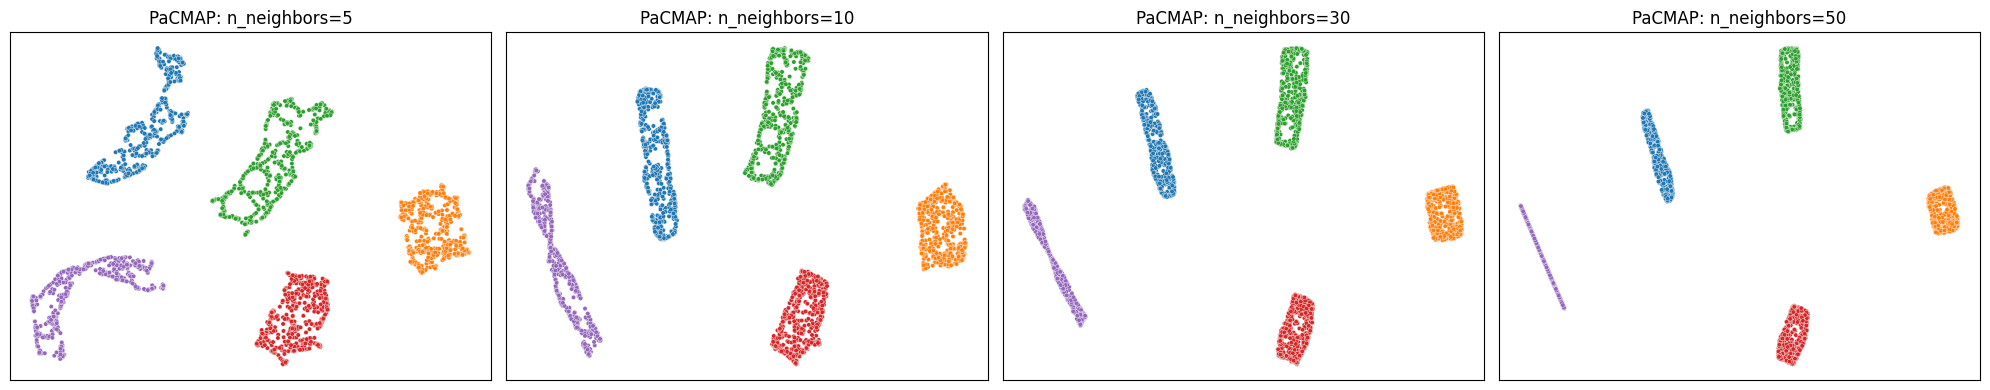

In [79]:
n_neighbors = [5, 10, 30, 50]

fig, axes = plt.subplots(1, len(n_neighbors), figsize=(5*len(n_neighbors), 4))

for j, n_neighbor in enumerate(n_neighbors):
    X_emb = run_pacmap(X_own_scaled, random_state=42, n_neighbors=n_neighbor)
    ax = axes[j]
    sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=y_own, palette="tab10", s=10, ax=ax, legend=False)
    ax.set_title(f"PaCMAP: n_neighbors={n_neighbor}")
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()


Calculating PHATE...
  Running PHATE on 2626 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.06 seconds.
  Calculating landmark operator...
    Calculating SVD...


c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\lib\site-packages\phate\phate.py:919: RuntimeWarning: Graph is disconnected with 5 connected components. This may indicate that your knn parameter (currently 5) is too small, or that your data contains distinct clusters. PHATE may not accurately represent relationships between disconnected components.
  warnings.warn(


    Calculated SVD in 0.41 seconds.
    Calculating KMeans...
    Calculated KMeans in 0.95 seconds.
  Calculated landmark operator in 1.36 seconds.
  Calculating optimal t...
    Automatically selected t = 56
  Calculated optimal t in 0.73 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.24 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.52 seconds.
Calculated PHATE in 4.17 seconds.
Calculating PHATE...
  Running PHATE on 2626 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating landmark operator...
    Calculating SVD...


c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\lib\site-packages\phate\phate.py:919: RuntimeWarning: Graph is disconnected with 5 connected components. This may indicate that your knn parameter (currently 10) is too small, or that your data contains distinct clusters. PHATE may not accurately represent relationships between disconnected components.
  warnings.warn(


    Calculated SVD in 0.20 seconds.
    Calculating KMeans...
    Calculated KMeans in 0.86 seconds.
  Calculated landmark operator in 1.07 seconds.
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 0.74 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.14 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.52 seconds.
Calculated PHATE in 3.80 seconds.
Calculating PHATE...
  Running PHATE on 2626 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.05 seconds.
  Calculated graph and diffusion operator in 0.11 seconds.
  Calculating landmark operator...
    Calculating SVD...


c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\lib\site-packages\phate\phate.py:919: RuntimeWarning: Graph is disconnected with 5 connected components. This may indicate that your knn parameter (currently 30) is too small, or that your data contains distinct clusters. PHATE may not accurately represent relationships between disconnected components.
  warnings.warn(


    Calculated SVD in 0.77 seconds.
    Calculating KMeans...
    Calculated KMeans in 0.98 seconds.
  Calculated landmark operator in 1.75 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 0.76 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.19 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.50 seconds.
Calculated PHATE in 4.56 seconds.
Calculating PHATE...
  Running PHATE on 2626 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.08 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 0.15 seconds.
  Calculating landmark operator...
    Calculating SVD...


c:\Users\User\Documents\Yandex.Disk\Магистратура\1 курс\2 трим\Кластеризация\venv\lib\site-packages\phate\phate.py:919: RuntimeWarning: Graph is disconnected with 5 connected components. This may indicate that your knn parameter (currently 50) is too small, or that your data contains distinct clusters. PHATE may not accurately represent relationships between disconnected components.
  warnings.warn(


    Calculated SVD in 0.21 seconds.
    Calculating KMeans...
    Calculated KMeans in 0.87 seconds.
  Calculated landmark operator in 1.08 seconds.
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 0.74 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.15 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.51 seconds.
Calculated PHATE in 3.89 seconds.


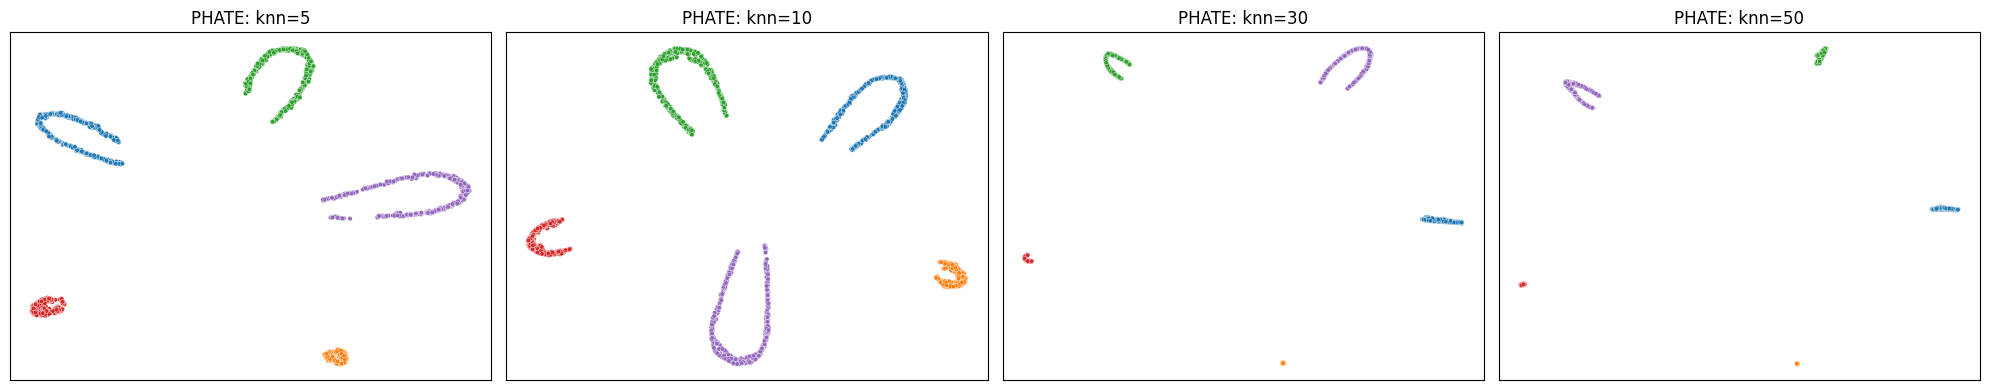

In [80]:
knns = [5, 10, 30, 50]

fig, axes = plt.subplots(1, len(knns), figsize=(5*len(knns), 4))

for j, knn in enumerate(knns):
    X_emb = run_phate(X_own_scaled, random_state=42, knn=knn)
    ax = axes[j]
    sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=y_own, palette="tab10", s=10, ax=ax, legend=False)
    ax.set_title(f"PHATE: knn={knn}")
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()


Обычно структура UMAP меняется плавнее, кластеры остаются узнаваемыми при разумном диапазоне параметров.

*Задача* Аналогично нужно сделать по одной строке графиков для TriMAP, PaCMAP, PHATE с варьированием ключевого параметра (количество соседей или похожий гиперпараметр) и показать, насколько устойчив рисунок.



| Метод  | Скорость на больших данных                   | Локальное разделение              | Глобальная структура                            | Чувствительность к параметрам                         | Комментарий                                        |
| ------ | -------------------------------------------- | --------------------------------- | ----------------------------------------------- | ----------------------------------------------------- | -------------------------------------------------- |
| t‑SNE  | Низкая l                    | Отличное                   | Слабая                                   | Высокая (perplexity, lr, random_state) aicompetence+2 | Хорошо для локальных кластеров, тяжёлый тюнинг     |
| UMAP   | Высокая l                   | Очень хорошее   | Лучшая, чем у t‑SNE           | Ниже, чем у t‑SNE aicompetence+2                      | Хороший баланс локал/глобал, удобен в практике     |
| TriMAP | Средняя                              | Хорошее                   | Сильный упор на глобальную структуру    | Умеренная                                     | Лучше показывает относительное положение кластеров |
| PaCMAP | Средняя                               | Отличное                   | Хорошее                                  | Умеренная                                      | Часто даёт чёткие кластеры и форму многобразия     |
| PHATE  | Средняя/низкая (зависит от размера)   | Хорошее        | Очень хорошее, особенно для траекторий   | Умеренная                          | Сильный метод для непрерывных переходов            |

# Варианты препроцессинга
*Задача* — явно сравнить, как UMAP и t‑SNE реагируют на разные варианты нормировки и отбора признаков.

## Определяем три сценария
Без масштабирования (сырой набор признаков).

StandardScaler (z‑нормировка).

MinMaxScaler + отбор признаков по дисперсии (эмуляция feature selection).

Задание. Проделать все три сценария. Обучить все модели при разных сценария кластеризации. 
Нужно в результате:
1. описать, какие признаки были отброшены и почему это может влиять на качество кластеризации во вложенном пространстве.
1. сравнить вычислительное время и сделать вывод о масштабируемости методов
1. изменить гиперпараметры (perplexity, n_neighbors, min_dist) и исследовать совместное влияние гиперпараметров и препроцессинга на структуру кластеров.


In [98]:
import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
import numpy as np


In [104]:
min_max_scaler = MinMaxScaler()
X_own_minmax = min_max_scaler.fit_transform(X_own)

standard_scaler = StandardScaler()
X_own_standard = standard_scaler.fit_transform(X_own)

variance_threshold = VarianceThreshold(threshold=0.1)
X_own_minmax_selected = variance_threshold.fit_transform(X_own_minmax)

print("Оригинальная размерность:", X_own.shape[1])
print(f"После MinMaxScaler + VarianceThreshold (threshold=0.01): {X_own_minmax_selected.shape[1]} признаков")

Оригинальная размерность: 8
После MinMaxScaler + VarianceThreshold (threshold=0.01): 7 признаков


## t-SNE

t-SNE сырые данные


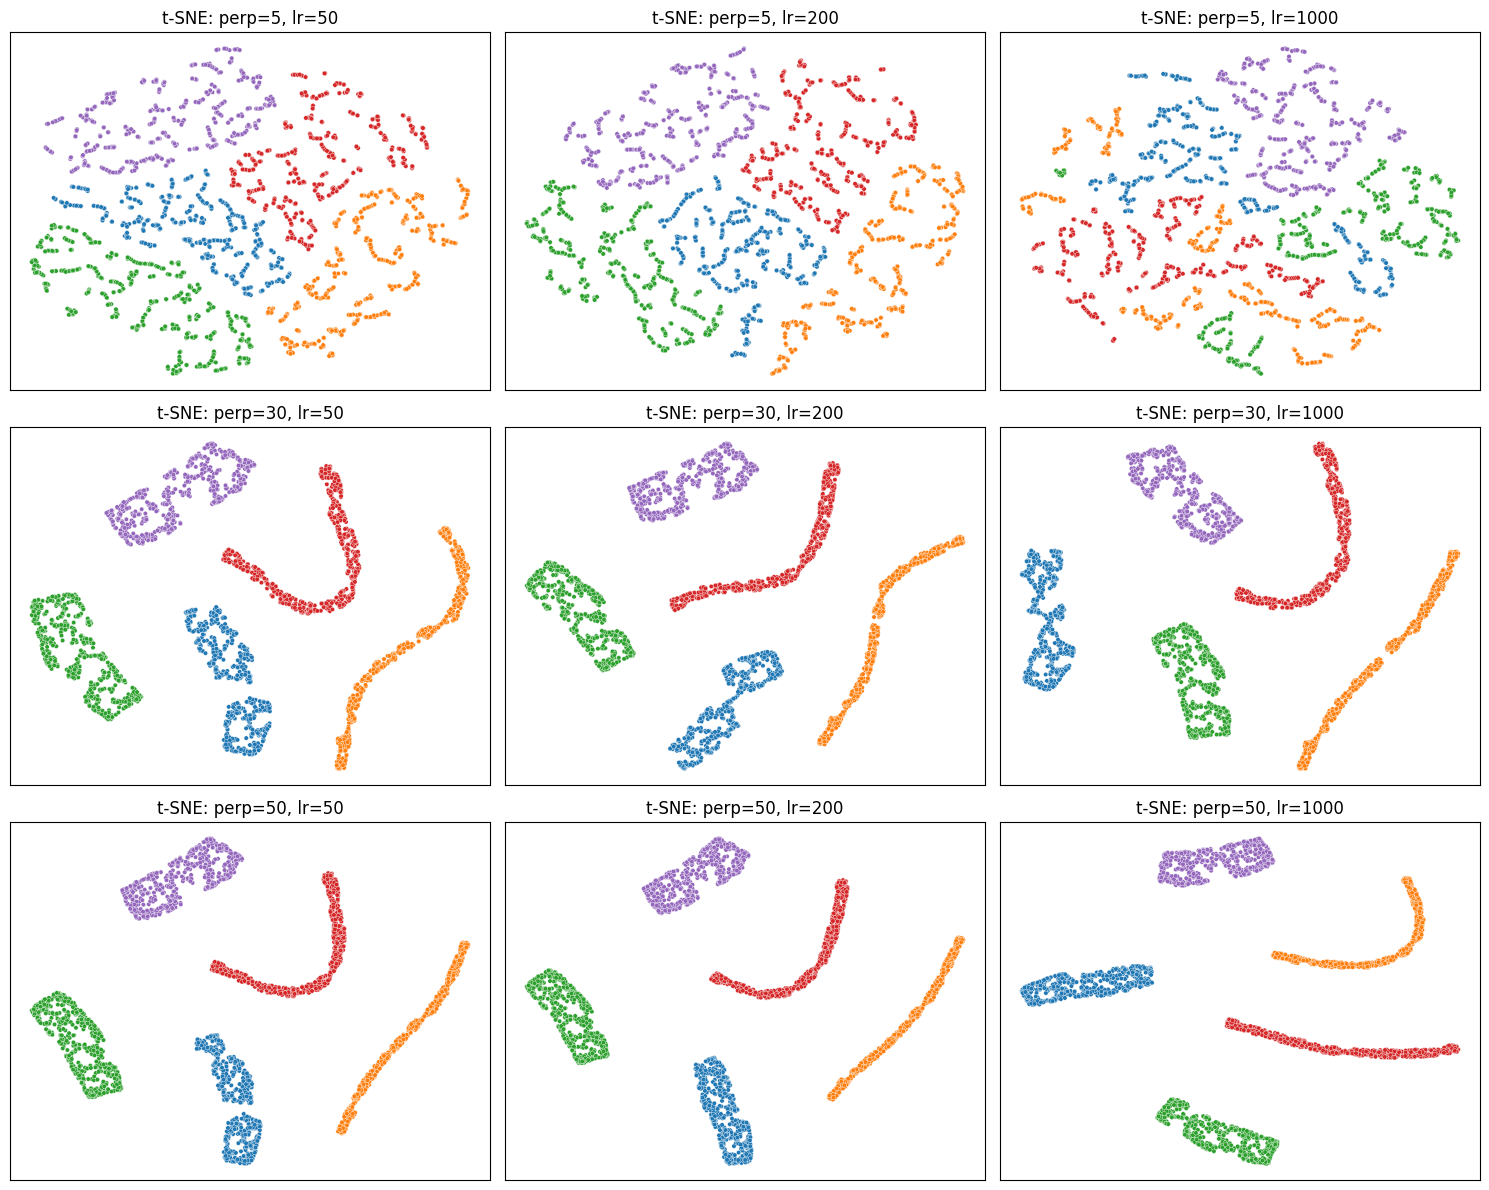

Всего времени:  0:00:35.909746


In [106]:
print("t-SNE сырые данные")
start_time = datetime.datetime.now()
perplexities = [5, 30, 50]
lrs = [50, 200, 1000]

fig, axes = plt.subplots(len(perplexities), len(lrs), figsize=(5*len(lrs), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(lrs):
        X_emb = run_tsne(X_own, random_state=42, perplexity=perp, learning_rate=lr)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=y_own, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"t-SNE: perp={perp}, lr={lr}")
        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

end_time = datetime.datetime.now()
print("Всего времени: ", end_time-start_time)

t-SNE StandartScaler


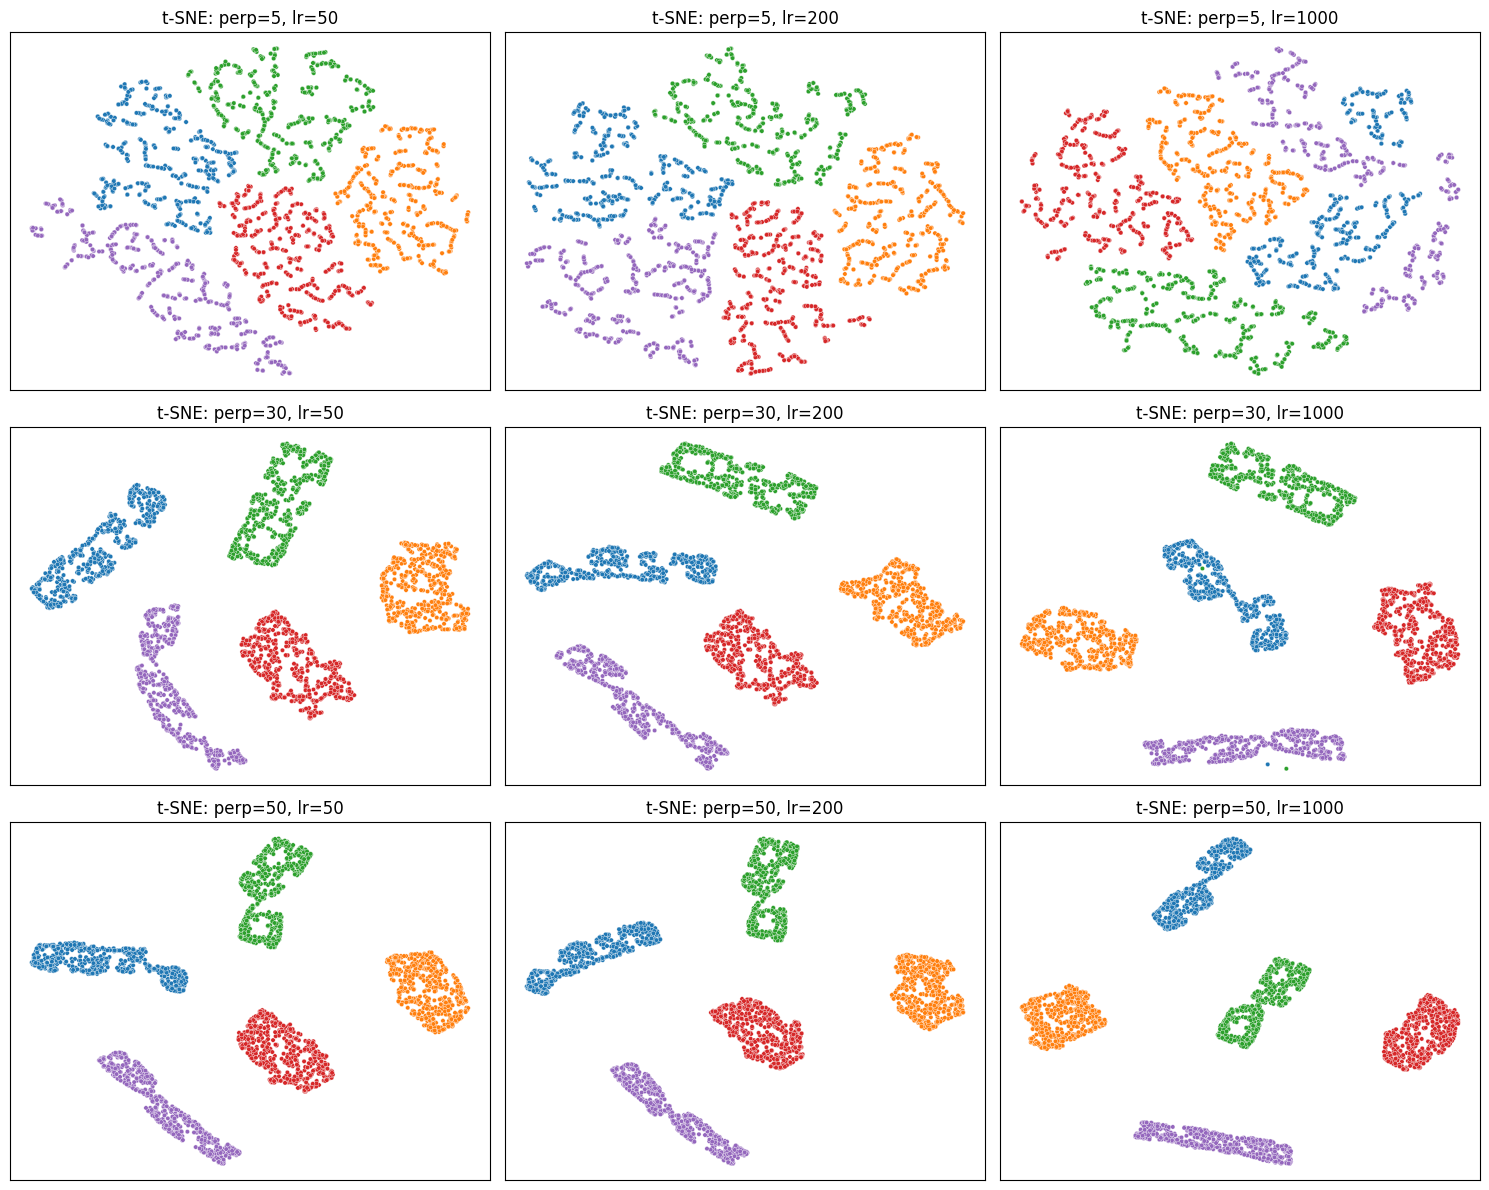

In [107]:
print("t-SNE StandartScaler")
perplexities = [5, 30, 50]
lrs = [50, 200, 1000]

fig, axes = plt.subplots(len(perplexities), len(lrs), figsize=(5*len(lrs), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(lrs):
        X_emb = run_tsne(X_own_scaled, random_state=42, perplexity=perp, learning_rate=lr)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=y_own, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"t-SNE: perp={perp}, lr={lr}")
        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()


t-SNE MinMaxScaler


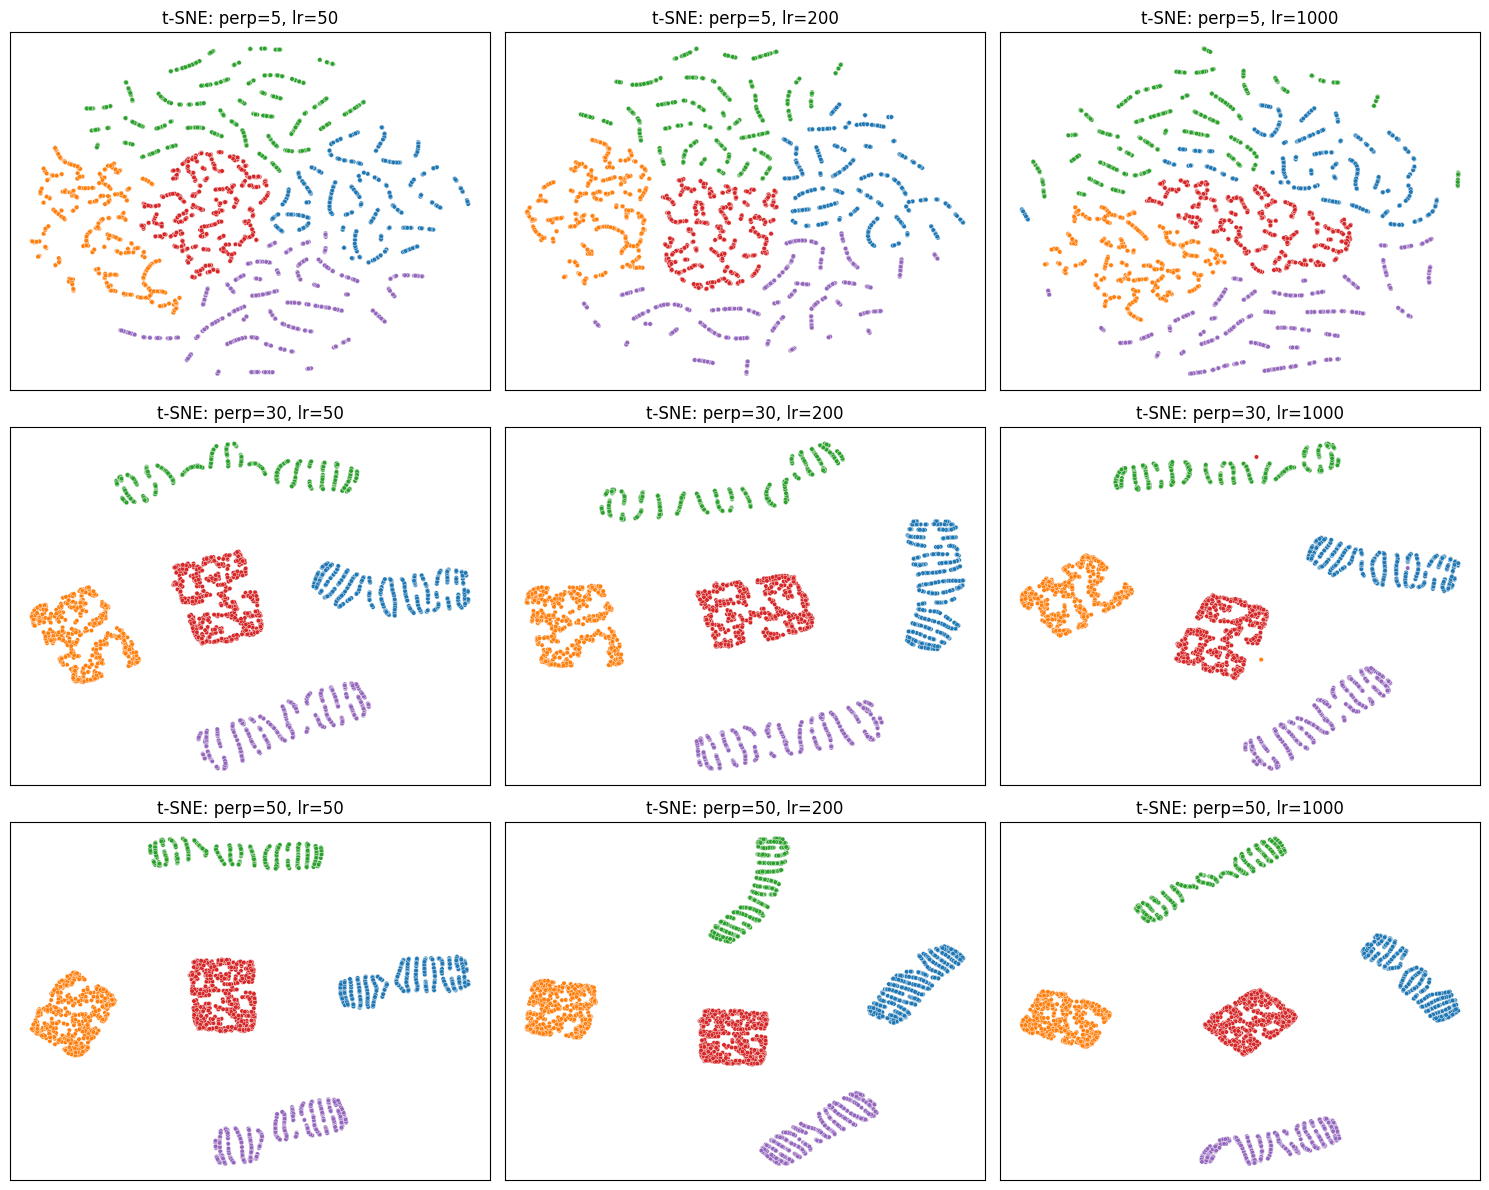

Всего времени:  0:00:35.434366


In [105]:
print("t-SNE MinMaxScaler")
start_time = datetime.datetime.now()
perplexities = [5, 30, 50]
lrs = [50, 200, 1000]

fig, axes = plt.subplots(len(perplexities), len(lrs), figsize=(5*len(lrs), 4*len(perplexities)))

for i, perp in enumerate(perplexities):
    for j, lr in enumerate(lrs):
        X_emb = run_tsne(X_own_minmax_selected, random_state=42, perplexity=perp, learning_rate=lr)
        ax = axes[i, j]
        sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=y_own, palette="tab10", s=10, ax=ax, legend=False)
        ax.set_title(f"t-SNE: perp={perp}, lr={lr}")
        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

end_time = datetime.datetime.now()
print("Всего времени: ", end_time-start_time)